In [8]:
import os
import copy
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import MobileNetV2, resnet18


model = resnet18()

data_dir = os.path.abspath("./data")
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.RandomErasing()])
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_sub_len = int(len(trainset) * 0.01)
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_sub_len, len(trainset) - train_sub_len])
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=2)

n_epochs = 3
opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    for images, labels in trainloader:
        opt.zero_grad()
        out = model(images)
        loss = loss_fn(out, labels)
        loss.backward()
        opt.step()

        
best_model_wts = copy.deepcopy(model.state_dict())
model.load_state_dict(best_model_wts)         
torch.save(model.state_dict(), './results/resnet.pth')

Files already downloaded and verified


In [9]:
in_model = resnet18()
in_model.load_state_dict(torch.load('./results/resnet.pth'))

torch.onnx.export(in_model,               
                  images,                         
                  './results/resnet.onnx',   
                  export_params=True,             
                  do_constant_folding=True,  
                  input_names = ['input'],   
                  output_names = ['output'], 
                  dynamic_axes={'input' : {0 : 'batch_size'},   
                                'output' : {0 : 'batch_size'}})

Files already downloaded and verified
(10000, 1000)
[[3.0126469e-03 2.0518573e-03 6.2473625e-04 ... 1.2990792e-03
  5.5749542e-03 6.4825616e-04]
 [6.6165671e-06 1.3274011e-04 2.6110688e-04 ... 7.1858613e-06
  5.1721225e-05 9.5716090e-04]]


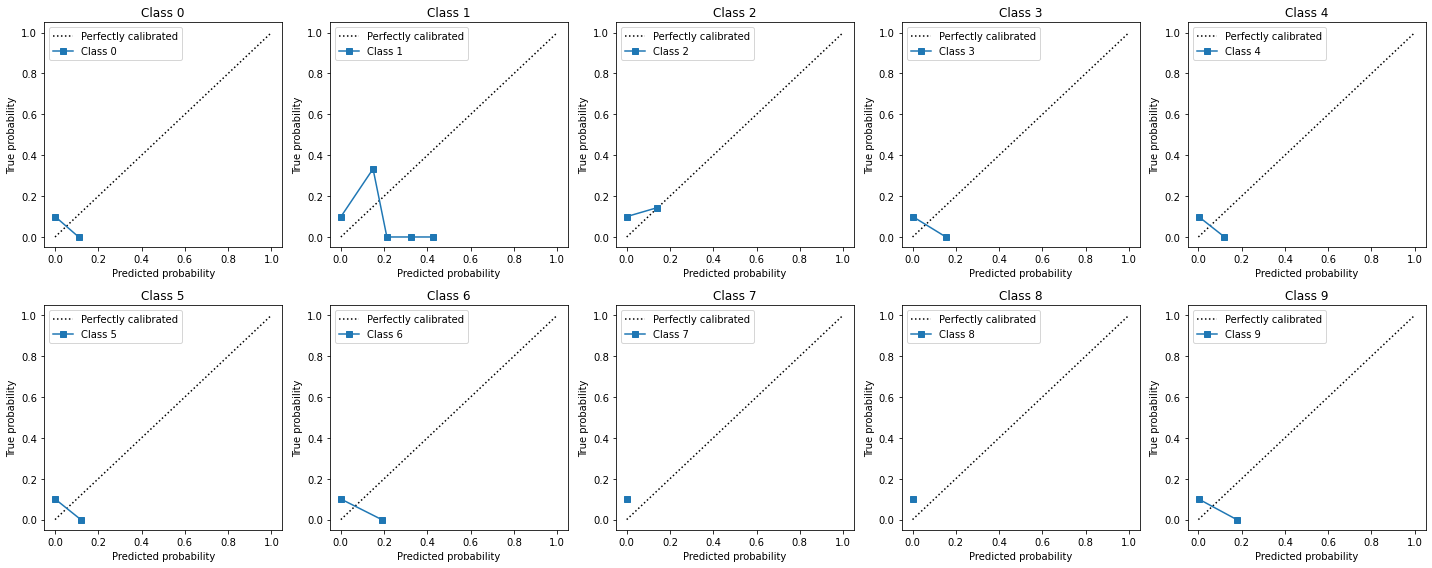

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import torch
from torchvision import datasets, transforms
import torchvision.models as models

# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.eval()

# Compute the predicted probabilities for each class
y_prob = []
y_true = []

with torch.no_grad():
    for images, labels in testset:
        outputs = model(images.unsqueeze(0))
        probs = torch.softmax(outputs, dim=1)
        y_prob.append(probs.numpy()[0])
        y_true.append(labels)

y_prob = np.array(y_prob)
print(y_prob.shape)
print(y_prob[0:2])
y_true = np.array(y_true)

# Plot the calibration curve for each class
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    prob_true, prob_pred = calibration_curve(y_true == i, y_prob[:, i], n_bins=10)
    ax.plot(prob_pred, prob_true, "s-", label="Class %d" % i)
    ax.set_title('Class %d' % i)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability')
    ax.legend()
    
plt.tight_layout()
plt.show()


Files already downloaded and verified


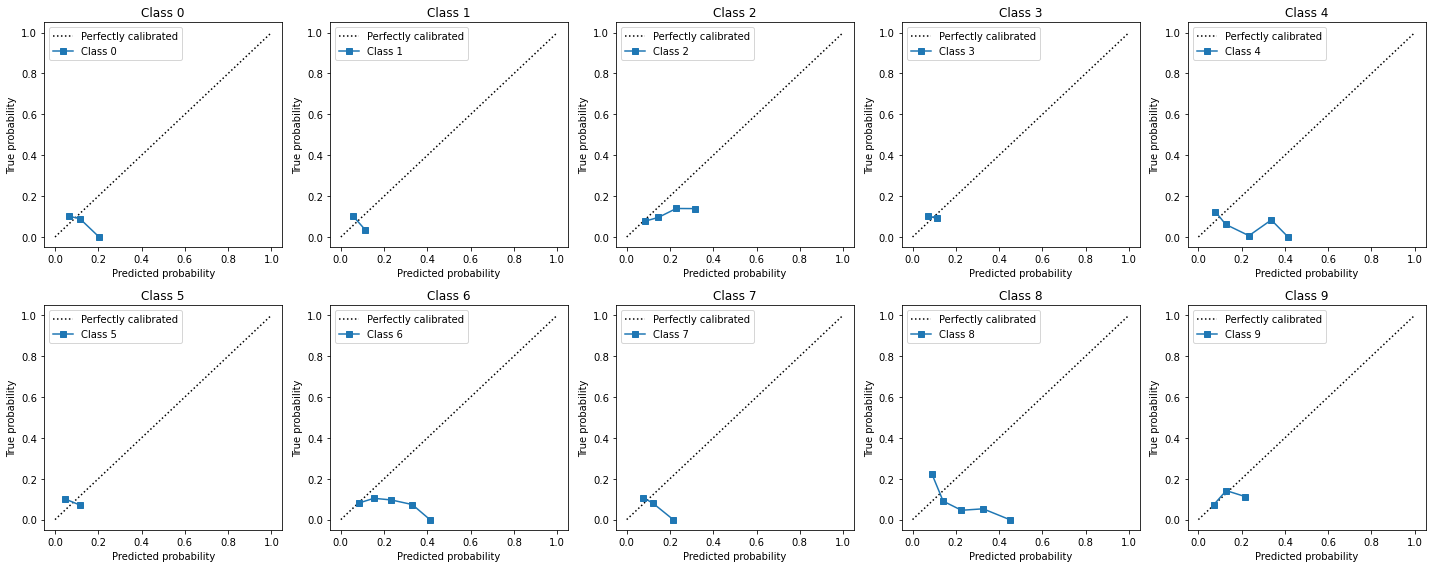

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import torch
from torchvision import datasets, transforms
import torchvision.models as models

# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify last layer to have the same number of classes as CIFAR-10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)

model.eval()

# Compute the predicted probabilities for each class
y_prob = []
y_true = []

with torch.no_grad():
    for images, labels in testset:
        outputs = model(images.unsqueeze(0))
        probs = torch.softmax(outputs, dim=1)
        y_prob.append(probs.numpy()[0])
        y_true.append(labels)

y_prob = np.array(y_prob)
y_true = np.array(y_true)

# Plot the calibration curve for each class
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    prob_true, prob_pred = calibration_curve(y_true == i, y_prob[:, i], n_bins=10)
    ax.plot(prob_pred, prob_true, "s-", label="Class %d" % i)
    ax.set_title('Class %d' % i)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability')
    ax.legend()
    
plt.tight_layout()
plt.show()


Files already downloaded and verified


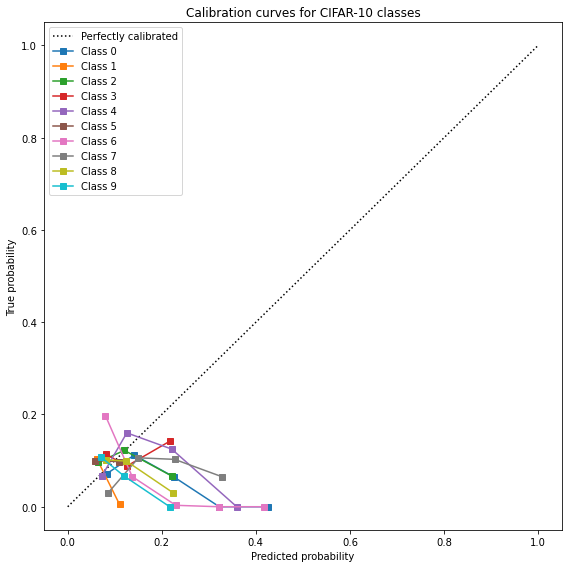

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import torch
from torchvision import datasets, transforms
import torchvision.models as models

# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify last layer to have the same number of classes as CIFAR-10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)

model.eval()

# Compute the predicted probabilities for each class
y_prob = []
y_true = []

with torch.no_grad():
    for images, labels in testset:
        outputs = model(images.unsqueeze(0))
        probs = torch.softmax(outputs, dim=1)
        y_prob.append(probs.numpy()[0])
        y_true.append(labels)

y_prob = np.array(y_prob)
y_true = np.array(y_true)

# Plot the calibration curve for each class
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for i in range(10):
    prob_true, prob_pred = calibration_curve(y_true == i, y_prob[:, i], n_bins=10)
    ax.plot(prob_pred, prob_true, "s-", label="Class %d" % i)
ax.set_title('Calibration curves for CIFAR-10 classes')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()

plt.tight_layout()
plt.show()
